<a href="https://colab.research.google.com/github/tonyw54/GeorgeBrown/blob/main/Misogyny_classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
# !wget https://aclanthology.org/attachments/2021.eacl-main.114.Dataset.zip
# !unzip 2021.eacl-main.114.Dataset.zip

--2024-09-20 00:22:18--  https://aclanthology.org/attachments/2021.eacl-main.114.Dataset.zip
Resolving aclanthology.org (aclanthology.org)... 174.138.37.75
Connecting to aclanthology.org (aclanthology.org)|174.138.37.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2173869 (2.1M) [application/zip]
Saving to: ‘2021.eacl-main.114.Dataset.zip.1’

2021.eacl-main.114. 100%[===================>]   2.07M  1.21MB/s    in 1.7s    

2024-09-20 00:22:21 (1.21 MB/s) - ‘2021.eacl-main.114.Dataset.zip.1’ saved [2173869/2173869]

Archive:  2021.eacl-main.114.Dataset.zip
replace data/final_labels.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [18]:
!pip install datasets

In [19]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [20]:
data = pd.read_csv("data/final_labels.csv")
label_encoder = LabelEncoder()
data["level_1_encoded"] = label_encoder.fit_transform(data["level_1"])
labels_encoded = torch.tensor(data["level_1_encoded"].tolist())

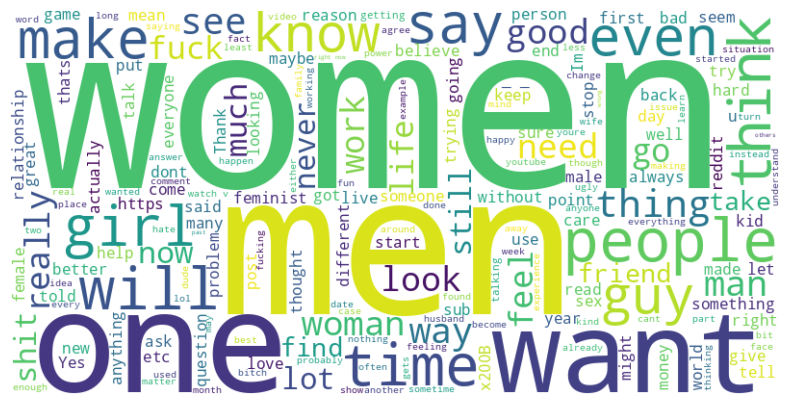

In [21]:
text = " ".join(data["body"].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
sentences = data["body"].astype(str).fillna("").tolist()
labels = labels_encoded

# Using BERT for tokenization
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Encode sentences and pad/truncate them
max_length = 50
encodings = tokenizer(sentences, padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Split data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(encodings['input_ids'], labels, test_size=0.2)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [23]:
# Create Dataset class
class SentenceDataset(Dataset):
    def __init__(self, sentences, labels):
        self.sentences = sentences
        self.labels = labels

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}

In [24]:
# Create DataLoader
train_dataset = SentenceDataset(train_sentences, train_labels)
val_dataset = SentenceDataset(val_sentences, val_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

In [25]:
# Using a fresh model because many Bert classifier models area biased.
# Lest's see if we can create a new model without the Bert sexism
import torch.nn as nn

class RNNClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, vocab_size):
        super(RNNClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=10, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # Get the embeddings for each word
        lstm_out, (hn, cn) = self.lstm(embedded)  # LSTM output
        final_output = hn[-1]  # Get the last hidden state
        out = self.fc(final_output)  # Feed it through a fully connected layer
        return self.sigmoid(out)


In [26]:
# Model parameters
vocab_size = len(tokenizer.vocab)
embedding_dim = 128
hidden_dim = 512
output_dim = 1  # Binary classification (0 or 1)

In [27]:
# Create the model, loss function, and optimizer
model = RNNClassifier(embedding_dim, hidden_dim, output_dim, vocab_size)
criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []
train_recalls = []
val_recalls = []
train_f1s = []
val_f1s = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_true = []

    for batch in train_loader:
        sentences = batch['sentence']
        labels = batch['label'].float()  # Convert labels to float for BCE loss

        optimizer.zero_grad()
        outputs = model(sentences)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend((outputs.squeeze() > 0.5).cpu().numpy().tolist())
        train_true.extend(labels.cpu().numpy().tolist())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_accuracy = accuracy_score(train_true, train_preds)
    train_accuracies.append(train_accuracy)

    train_precision = precision_score(train_true, train_preds, zero_division=0)
    train_precisions.append(train_precision)

    train_recall = recall_score(train_true, train_preds, zero_division=0)
    train_recalls.append(train_recall)

    train_f1 = f1_score(train_true, train_preds, zero_division=0)
    train_f1s.append(train_f1)

    model.eval()
    val_loss = 0
    val_preds = []
    val_true = []

    with torch.no_grad():
        for batch in val_loader:
            sentences = batch['sentence']
            labels = batch['label'].float()

            outputs = model(sentences)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

            val_preds.extend((outputs.squeeze() > 0.5).cpu().numpy().tolist())
            val_true.extend(labels.cpu().numpy().tolist())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = accuracy_score(val_true, val_preds)
    val_accuracies.append(val_accuracy)

    val_precision = precision_score(val_true, val_preds, zero_division=0)
    val_precisions.append(val_precision)

    val_recall = recall_score(val_true, val_preds, zero_division=0)
    val_recalls.append(val_recall)

    val_f1 = f1_score(val_true, val_preds, zero_division=0)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")





<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 1/10
Train Loss: 0.3516, Train Accuracy: 0.8942, Train Precision: 0.8942, Train Recall: 1.0000, Train F1: 0.9441
Val Loss: 0.3217, Val Accuracy: 0.8912, Val Precision: 0.8912, Val Recall: 1.0000, Val F1: 0.9425


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 2/10
Train Loss: 0.3164, Train Accuracy: 0.8961, Train Precision: 0.8974, Train Recall: 0.9979, Train F1: 0.9450
Val Loss: 0.3144, Val Accuracy: 0.8912, Val Precision: 0.8912, Val Recall: 1.0000, Val F1: 0.9425


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 3/10
Train Loss: 0.2976, Train Accuracy: 0.8989, Train Precision: 0.9099, Train Recall: 0.9845, Train F1: 0.9457
Val Loss: 0.3114, Val Accuracy: 0.8950, Val Precision: 0.9083, Val Recall: 0.9812, Val F1: 0.9433


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 4/10
Train Loss: 0.2839, Train Accuracy: 0.9117, Train Precision: 0.9200, Train Recall: 0.9870, Train F1: 0.9523
Val Loss: 0.3175, Val Accuracy: 0.8988, Val Precision: 0.9113, Val Recall: 0.9821, Val F1: 0.9453


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 5/10
Train Loss: 0.2740, Train Accuracy: 0.9189, Train Precision: 0.9257, Train Recall: 0.9887, Train F1: 0.9561
Val Loss: 0.3174, Val Accuracy: 0.9003, Val Precision: 0.9134, Val Recall: 0.9812, Val F1: 0.9461


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 6/10
Train Loss: 0.2657, Train Accuracy: 0.9229, Train Precision: 0.9277, Train Recall: 0.9911, Train F1: 0.9583
Val Loss: 0.3108, Val Accuracy: 0.8973, Val Precision: 0.9157, Val Recall: 0.9744, Val F1: 0.9441


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 7/10
Train Loss: 0.2543, Train Accuracy: 0.9259, Train Precision: 0.9313, Train Recall: 0.9902, Train F1: 0.9599
Val Loss: 0.3144, Val Accuracy: 0.8988, Val Precision: 0.9159, Val Recall: 0.9761, Val F1: 0.9450


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 8/10
Train Loss: 0.2459, Train Accuracy: 0.9307, Train Precision: 0.9330, Train Recall: 0.9938, Train F1: 0.9625
Val Loss: 0.3019, Val Accuracy: 0.9003, Val Precision: 0.9173, Val Recall: 0.9761, Val F1: 0.9458


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 9/10
Train Loss: 0.2407, Train Accuracy: 0.9326, Train Precision: 0.9347, Train Recall: 0.9940, Train F1: 0.9635
Val Loss: 0.3201, Val Accuracy: 0.8957, Val Precision: 0.9217, Val Recall: 0.9650, Val F1: 0.9428


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}
<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Epoch 10/10
Train Loss: 0.2346, Train Accuracy: 0.9347, Train Precision: 0.9363, Train Recall: 0.9947, Train F1: 0.9646
Val Loss: 0.3027, Val Accuracy: 0.9011, Val Precision: 0.9147, Val Recall: 0.9804, Val F1: 0.9464


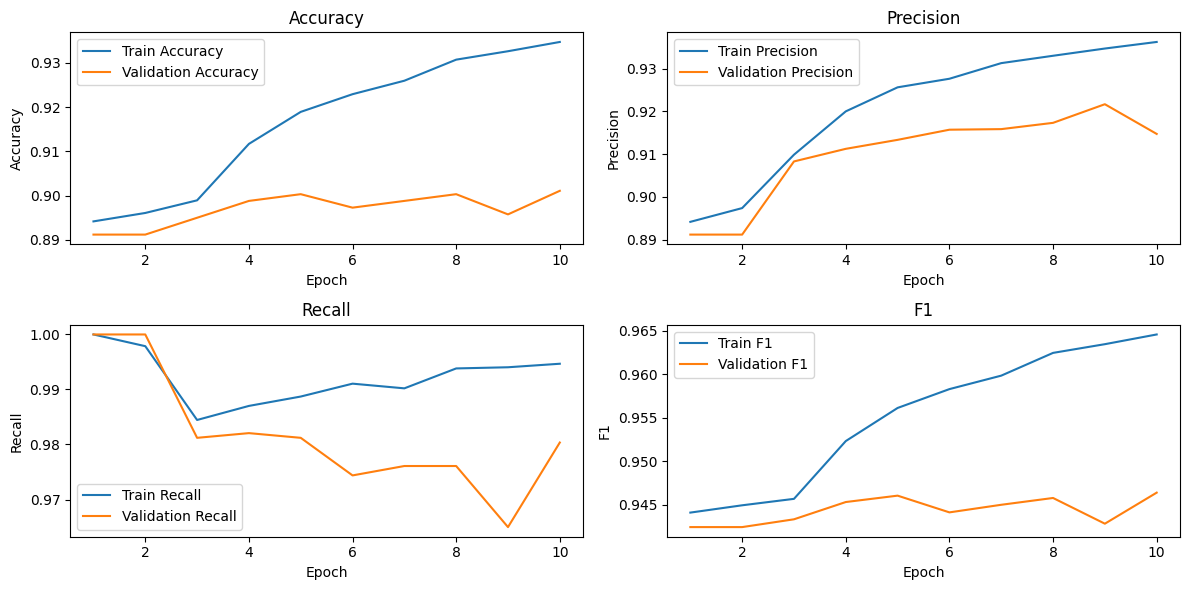

In [29]:
# Create a chart using matplotlib
epochs = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precisions, label="Train Precision")
plt.plot(epochs, val_precisions, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.title("Precision")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recalls, label="Train Recall")
plt.plot(epochs, val_recalls, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.title("Recall")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_f1s, label="Train F1")
plt.plot(epochs, val_f1s, label="Validation F1")
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.title("F1")
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        sentences = batch['sentence']
        labels = batch['label'].float()

        outputs = model(sentences).squeeze()
        predicted = (outputs > 0.5).float()  # Use 0.5 threshold for binary classification

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


Validation Accuracy: 90.11%


<ipython-input-23-60fc54cfa070>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {'sentence': self.sentences[idx], 'label': torch.tensor(self.labels[idx], dtype=torch.long)}


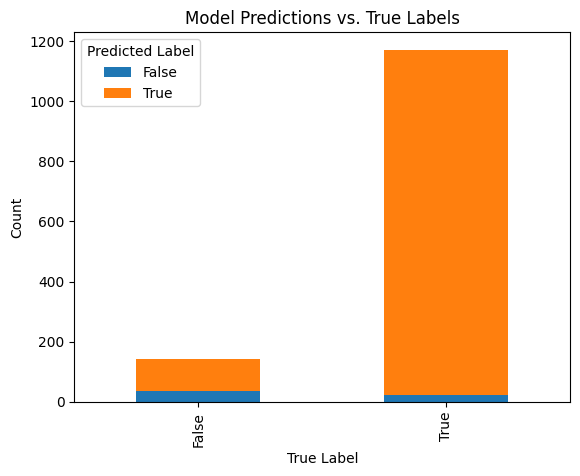

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
model.eval()  # Set the model to evaluation mode
all_val_predictions = []
all_val_labels = []

with torch.no_grad():
    for batch in val_loader:
        sentences = batch['sentence']
        labels = batch['label'].float()

        outputs = model(sentences).squeeze()
        predicted = (outputs > 0.5).float()  # Use 0.5 threshold for binary classification

        all_val_predictions.extend(predicted.tolist())
        all_val_labels.extend(labels.tolist())

# Convert predictions and labels to boolean values
predicted_labels_bool = [bool(pred) for pred in all_val_predictions]
true_labels_bool = [bool(label) for label in all_val_labels]

# Create a DataFrame for visualization
results_df = pd.DataFrame({'True Label': true_labels_bool, 'Predicted Label': predicted_labels_bool})

# Display the data in a chart (using a bar chart for example)
results_df['True Label'] = results_df['True Label'].astype(str)
results_df['Predicted Label'] = results_df['Predicted Label'].astype(str)

# Group by true and predicted labels and count occurrences
counts = results_df.groupby(['True Label', 'Predicted Label']).size().unstack()

# Plot the counts using a bar chart
counts.plot(kind='bar', stacked=True)
plt.xlabel('True Label')
plt.ylabel('Count')
plt.title('Model Predictions vs. True Labels')
plt.legend(title='Predicted Label')
plt.show()

In [34]:
def predict_sentence(sentence):
    test_encodings = tokenizer(sentence, padding=True, truncation=True, max_length=50, return_tensors='pt')
    with torch.no_grad():
        outputs = model(test_encodings['input_ids']).squeeze()
        predicted = (outputs > 0.5).float()
    return bool(predicted.item())

In [35]:
predict_sentence("It's math, dear. Don't worry your pretty little head about it.")

True

In [37]:
predict_sentence("International Women's day is on March 8.")

False

In [38]:
predict_sentence("Men tend to be mean to women.")

True

In [39]:
predict_sentence("Roses are red, violets are blue.")

True